In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyodbc
import sqlalchemy
import sqlite3
from subprocess import check_output
import os


from sqlalchemy import create_engine
engine = create_engine('sqlite:////...', echo=False)

## 1. Introduction to relational databases

In this kernel, you'll create your very first database with a set of `simple SQL commands`. 

Next, you'll `migrate data` from `existing flat tables` into that `database`. 

You'll also learn how `meta-information` about a `database` can be `queried`.

#### 1.1. Opening example: Investigating university in Switzerland
Look at the following picture

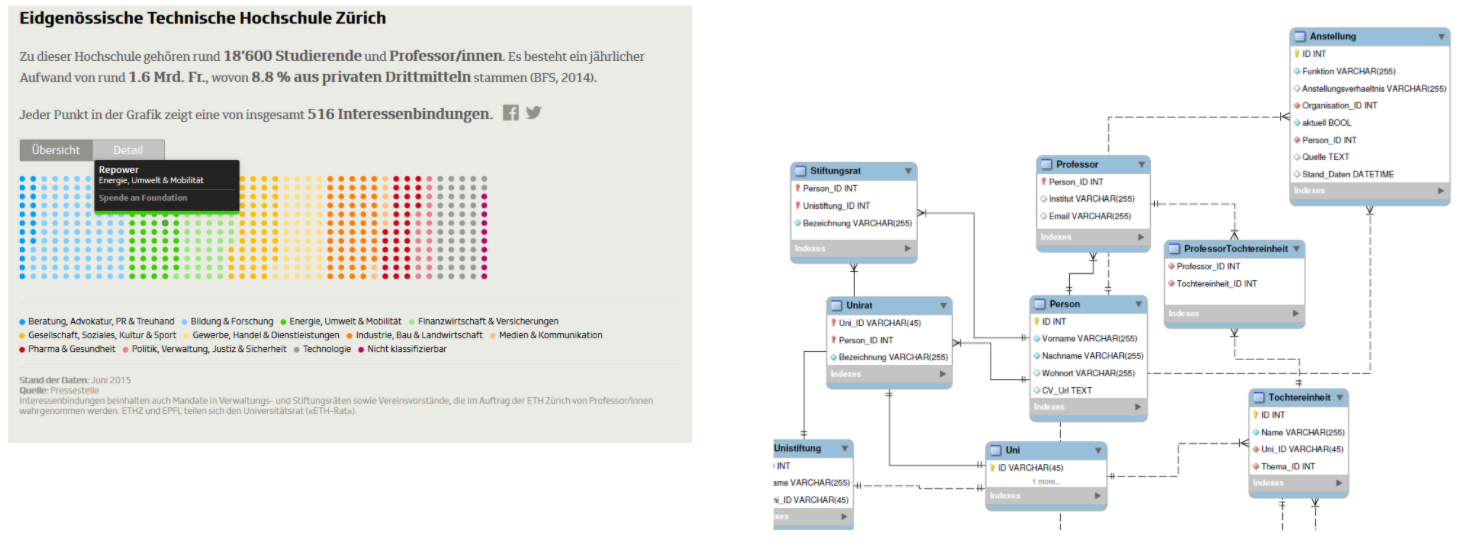

In [2]:
from IPython.core.display import Image, display
## INVESTIGATING UNIVERSITY IN SWITZERLAND

#### A relational database

|  Types                                 | Examples                                                          |
|----------------------------------------|-------------------------------------------------------------------|
| Real-life entities become tables       | `professors`, `universities`, `companies`, ....                   |
| Reduced redundancy                     | Only one the entry `in companies` for the `bank` `"Credit Suisse"`|
| Data integrity relationships           | `A profesor` can work at `multiple universities` and `companies`  |
|                                        |  `A company` can employ `multiple professors`.                    |

#### Throghout this course, you will:
> Work with the data I used for my investigation
>
> Create a `relational database` from `scratch`
>
> Learn these concepts: `contraints, keys` and `referential integrity`.

#### Your first duty: Look at the PostgreSQL database

In [3]:
pd.read_sql("""   
       SELECT table_schema, table_name
       FROM information_schema.tables
       ORDER BY table_name
       LIMIT 10
       """, con = engine)

,table_schema,table_name
0,information_schema,_pg_foreign_data_wrappers
1,information_schema,_pg_foreign_servers
2,information_schema,_pg_foreign_table_columns
3,information_schema,_pg_foreign_tables
4,information_schema,_pg_user_mappings
5,information_schema,administrable_role_authorizations
6,information_schema,applicable_roles
7,information_schema,attributes
8,information_schema,character_sets
9,information_schema,check_constraint_routine_usage


And now, look at the number of table_name in each group of table_schema:

In [4]:
pd.read_sql(
    """ 
        SELECT table_schema, COUNT(*)
        FROM information_schema.tables
        GROUP BY table_schema
    """, con = engine)

,table_schema,count
0,public,1
1,pg_catalog,121
2,information_schema,67


#### Next, have a look at the column of a certain table

In [5]:
pd.read_sql(
    """ 
        SELECT table_schema, table_name, column_name, data_type
        FROM information_schema.columns
        WHERE table_name = 'pg_config'
    """, con = engine)

,table_schema,table_name,column_name,data_type
0,pg_catalog,pg_config,name,text
1,pg_catalog,pg_config,setting,text


And how about the `data_type`?

In [6]:
pd.read_sql(
    """ 
        SELECT data_type, COUNT(*)
        FROM information_schema.columns
        GROUP BY data_type
    """, con = engine)

,data_type,count
0,abstime,2
1,interval,5
2,smallint,24
3,name,140
4,inet,2
5,pg_node_tree,13
6,boolean,113
7,text,114
8,anyarray,9
9,regproc,34


### EXERCISEs
#### Question 1. Attributes of relational databases
In the preceding, we talked about some basic facts about relational databases. Which of the following statements **does not hold true for databases?**
> **A.** `Relational databases (R.D)` store different real-world entities in different tables.
>
> **B.** `Relational databases` allow to establish relationships between entities.
>
> **C.** `Relational databases` are called "relational" because they store data only about people.
>
> **D.** `Relational databases` use constraints, keys and referential integrity in order to assure data quality.

    |=================================================================================================|
    |                                    Explain & answers:                                           |
    |=================================================================================================|
    | A. Wrong. Because the R.D holds the different real-world entities in different tables.          |
    *-------------------------------------------------------------------------------------------------*
    | B. Wrong. Since it is a key advantage of databases that they allow to model relationships       |
    |    between different kinds of objects.                                                          |     
    *-------------------------------------------------------------------------------------------------*
    | C. This is a correct answer! Of course, databases can also store information about any other    |
    |    kind of entities, e.g. spare car parts.                                                      |
    *-------------------------------------------------------------------------------------------------*
    | D. If used correctly, these concepts make your life easier ensuring data quality. Therefore,    |
    |    the answer you selected is wrong.                                                            |
    |=================================================================================================|

#### Exercise 1.2. Query information_schema with SELECT
`information_schema` is a `meta-database` that holds information about your current database. `information_schema` has multiple tables you can query with the known `SELECT * FROM` syntax:

> `tables:` information about all tables in your current database
>
> `columns:` information about all columns in all of the tables in your current database
>
> `…`

In this exercise, you'll only need information from the `'public'` schema, which is specified as the column `table_schema` of the tables and columns tables. The `'public'` schema holds information about `user-defined` tables and databases. The other types of `table_schema` hold system information – for this course, you're only interested in user-defined stuff.

#### Instructions 
**Step 1.** Get `information` on all table `names` in the current database, while limiting your query to the `'public'` `table_schema`.

In [7]:
pd.read_sql(
    """ 
    -- Query the right table in information_schema
    SELECT table_name 
    FROM information_schema.tables
    -- Specify the correct table_schema value
    WHERE table_schema = 'public';
    """, con = engine)

,table_name
0,university_professors


**Step 2.** Now have a look at the columns in `university_professors` by selecting all entries in `information_schema.columns` that correspond to that table.

In [8]:
pd.read_sql(
    """ 
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name = 'university_professors' AND table_schema = 'public';
    """, con = engine)

,column_name,data_type
0,firstname,text
1,lastname,text
2,university,text
3,university_shortname,text
4,university_city,text
5,function,text
6,organization,text
7,organization_sector,text


**Step 3.** Look inside the table `university_professors` and extract the first 5 values order by their names

In [9]:
pd.read_sql(
    """ 
    -- Query the first five rows of our table
    SELECT * 
    FROM university_professors 
    LIMIT 5;
    """, con = engine)

,firstname,lastname,university,university_shortname,university_city,function,organization,organization_sector
0,Karl,Aberer,ETH Lausanne,EPF,Lausanne,Chairman of L3S Advisory Board,L3S Advisory Board,Education & research
1,Karl,Aberer,ETH Lausanne,EPF,Lausanne,Member Conseil of Zeno-Karl Schindler Foundation,Zeno-Karl Schindler Foundation,Education & research
2,Karl,Aberer,ETH Lausanne,EPF,Lausanne,Member of Conseil Fondation IDIAP,Fondation IDIAP,Education & research
3,Karl,Aberer,ETH Lausanne,EPF,Lausanne,Panel Member,SNF Ambizione Program,Education & research
4,Reza Shokrollah,Abhari,ETH Zürich,ETH,Zurich,Aufsichtsratsmandat,PNE Wind AG,"Energy, environment & mobility"


Great work! You're now familiar with the pre-existing `university_professors` table, which holds information on all kinds of `entities`. 

**Step 4.** Count the `distinct_values` of the columns: `university_city, university, function, organization` and `organization_sector`.

In [10]:
pd.read_sql(
    """ 
    SELECT COUNT(*) AS number_of_prof
            COUNT(DISTINCT university_city) AS number_cities,
            COUNT(DISTINCT university) AS number_univs,
            COUNT(DISTINCT function) AS number_func,
            COUNT(DISTINCT organization) AS number_organs,
            COUNT(DISTINCT organization_sector) AS number_organs_sectors
    FROM university_professors
    """, con = engine)

,number_of_prof,number_cities,number_univs,number_func,number_organs,number_organs_sectors
0,1377,9,11,731,1287,12


**Step 5.** count the professors and groupby the `oragnization_sectors` in the `university : ETH Lausanne`.

In [11]:
pd.read_sql(
    """ 
        SELECT organization_sector, COUNT(*) number_of_prof
        FROM university_professors 
        WHERE university = 'ETH Lausanne'
        GROUP BY organization_sector
        ORDER BY number_of_prof DESC
    """, con = engine)

,organization_sector,number_of_prof
0,Education & research,278
1,Technology,52
2,"Industry, construction & agriculture",37
3,Pharma & health,32
4,Media & communication,30
5,"Politics, administration, justice system & sec...",30
6,"Commerce, trade & services",28
7,Not classifiable,24
8,"Energy, environment & mobility",20
9,"Consulting, public relations, legal & trust",19


## 2. Tables: At the core of every database
#### Redundancy in the table `university_professors`
According to the Step3 in the previous exercise, Now, looking at the first we have `records` for examples        

    = [RECORD 1] ==========+=================================================================
    firstname              |   Karl
    lastname               |   Aberer
    university             |   ETH Lausanne
    university_shortname   |   EPF
    function               |   Chairman of L3S Advisory Board
    organization           |   L3S Advisory Board
    organization_sector    |   Education & research
    = [RECORD 2] ==========+=================================================================    
    firstname              |   Karl
    lastname               |   Aberer
    university             |   ETH Lausanne
    university_shortname   |   EPF
    function               |   Member Conseil of Zeno-Karl Schindler Foundation
    organization           |   Zeno-Karl Schindler Foundation
    organization_sector    |   Education & research
    = [RECORD 3] ==========+=================================================================
    firstname              |   Karl
    lastname               |   Aberer
    university             |   ETH Lausanne
    university_shortname   |   EPF
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ truncated ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    

#### 2.2. Entity types in database

**CASE 1 [Currently] One `"entity type" (old)`** and a **`"beter model" (new)`** with 3 `entity types`

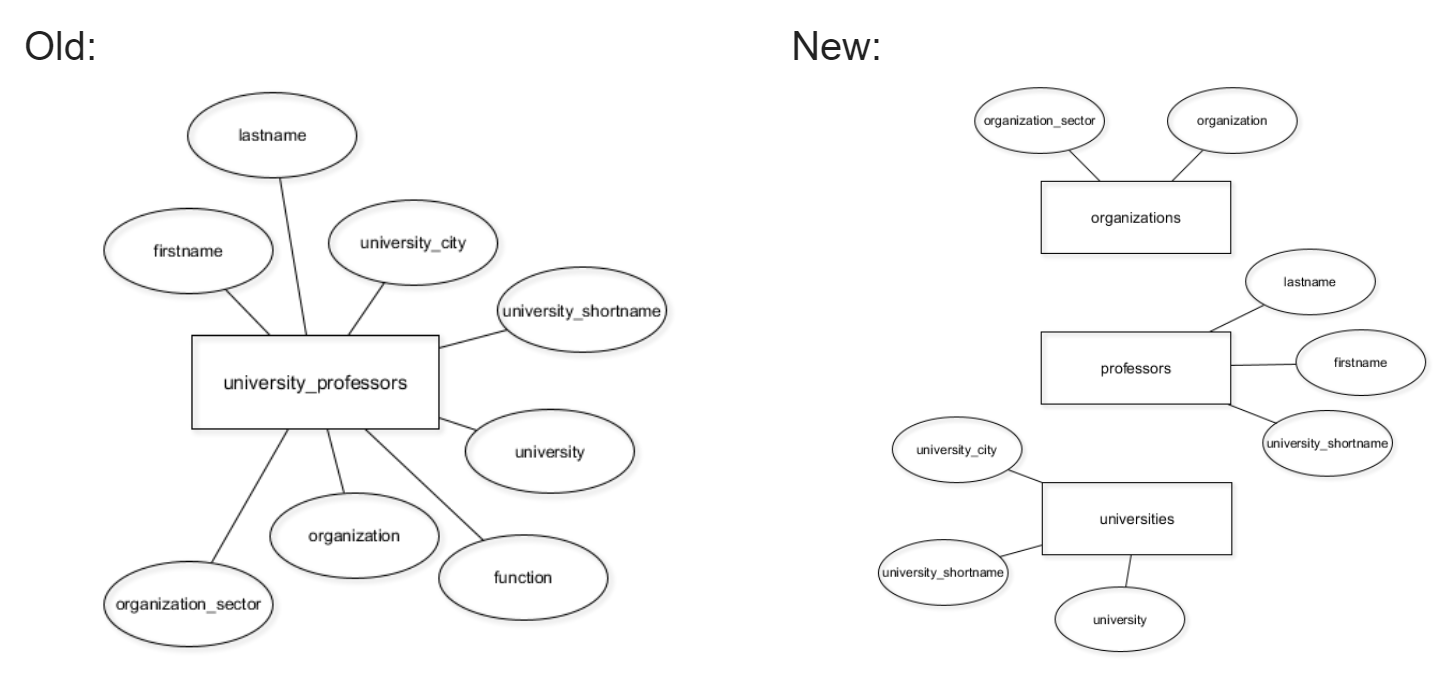

In [12]:
## Left (Old): current model with 1 entity type
## Right (New): better model with 3 enity types

And here is **4 `entity types`**

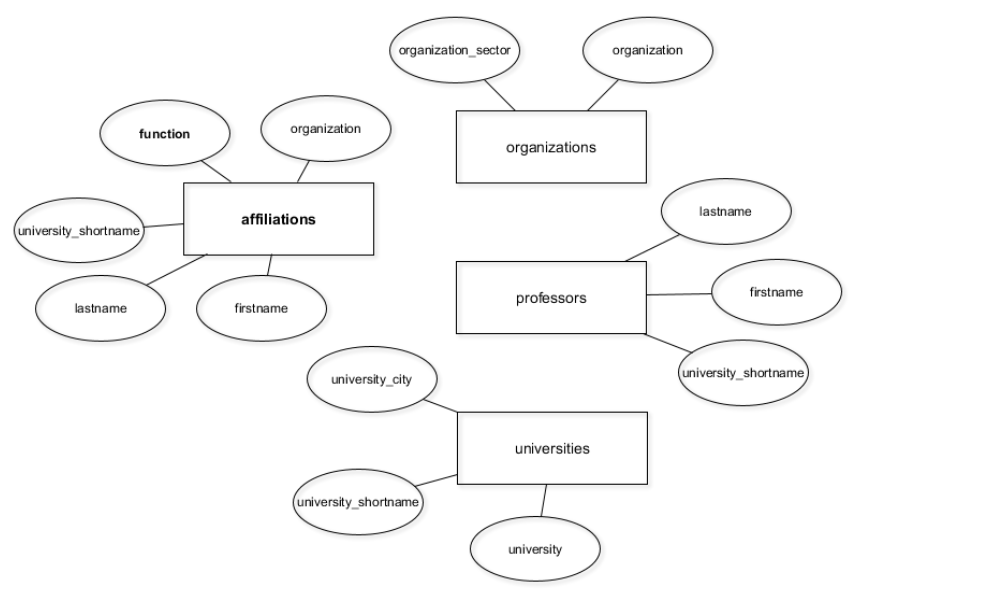

In [13]:
## 4 entity types

#### 2.3. How to create new tables in `SQL`?

Syntax, 

                CREATE TABLE table_name(
                                         column_a data_type_1,
                                         column_b data_type_2,
                                         ....
                                         column_k data_type...
                                          );

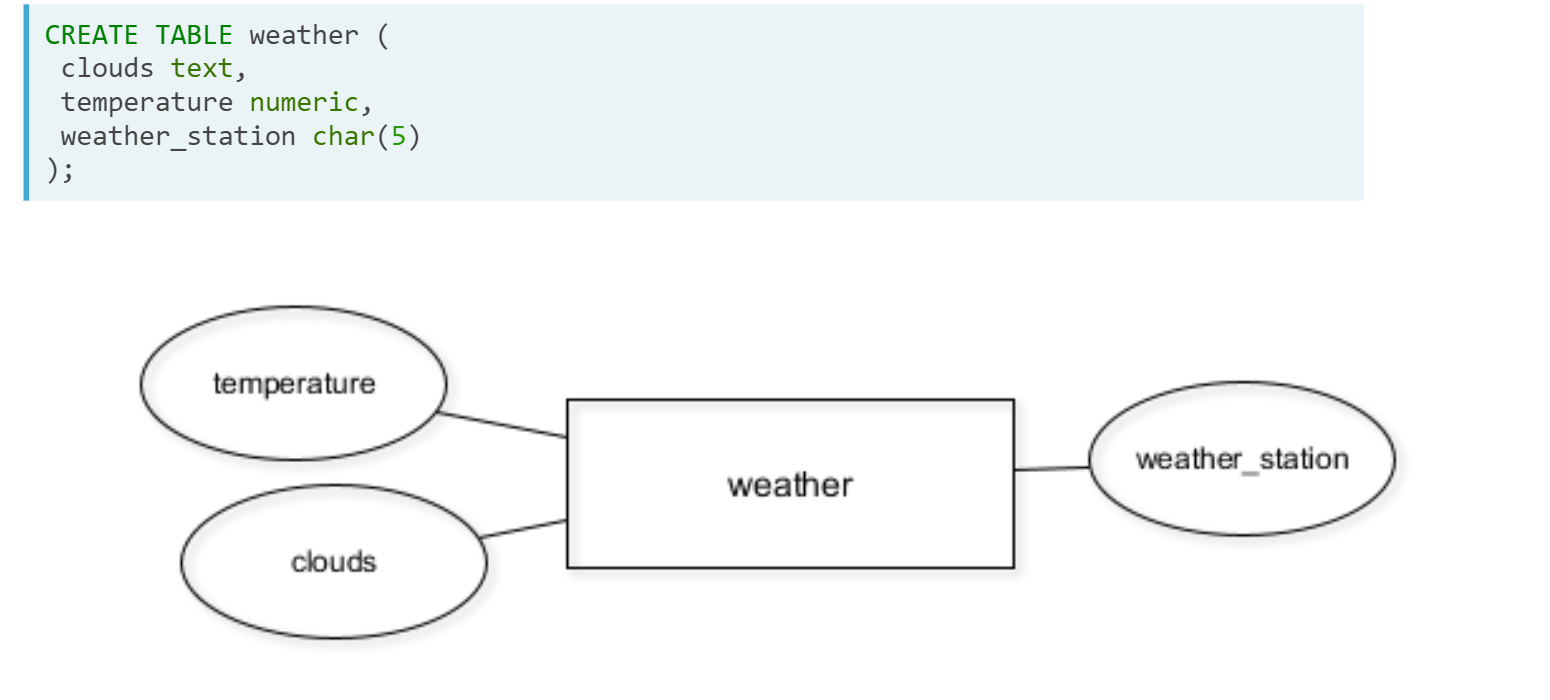

In [14]:
## hidden

### EXERCISEs. 

#### Exercise 2.2: `CREATE` your first few `TABLEs`
You'll now start implementing a better database model. For this, you'll create tables for the `professors` and `universities` entity types. The other tables will be created for you.

The syntax for creating simple tables is as the previous section,

**`Attention:`** Table and columns names, as well as data types, don't need to be surrounded by quotation marks.

#### Instructions
**Step 1.** Create a table `professors` with two text columns: `firstname` and `lastname`.

**`Solution`**.

        CREATE TABLE professors (
                                     firstname text,
                                     lastname text
                                    );

        -- Print the contents of this table
        SELECT * 
        FROM professors

**query result:**

| firstname |	lastname |
|-----------|------------|
|           |            |

**Step 2.** Create a table `universities` with three `text` columns: `university_shortname, university`, and `university_city`

**`Solution.`**

                -- Create a table for the universities entity type
                CREATE TABLE universities(
                                            university_shortname text,
                                            university text,
                                            university_city text
                                        );

                -- Print the contents of this table
                SELECT * 
                FROM universities
**query_result.**

| university_shortname |	university	| university_city   |
|----------------------|----------------|-------------------|
|                      |                |                   |

Great job. The other two tables, `affiliations` and `organizations`, will be created for you.

#### Exercise 2.3. ADD a COLUMN with ALTER TABLE
Oops! We forgot to add the `university_shortname` column to the `professors` table. You've probably already noticed (in the section 2.3 [])

In chapter 4 of this [course](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/tree/master/SQL%20practices/Track:%20SQL%20for%20Database%20Administrators/Course1:%20Introduction%20to%20Relational%20Databases%20in%20SQL), you'll need this column for connecting the professors table with the `universities` table.

However, adding columns to existing tables is easy, especially if they're still empty.

To add columns you can use the following `SQL query`:

                ALTER TABLE table_name
                ADD COLUMN column_name data_type;
#### Instructions.
Alter professors to add the text column university_shortname.

**`Solutions`**

            -- Add the university_shortname column
            ALTER TABLE professors
            ADD COLUMN university_shortname text;

            -- Print the contents of this table
            SELECT * 
            FROM professors
**query result.**

| firstname |	lastname |	university_shortname |
|-----------|------------|-----------------------|
|           |            |                       |

Perfect – now your first sample database model is complete. Time to fill these tables with data!

## 3. Update your database as the structure changes

#### 3.1. The current database model.

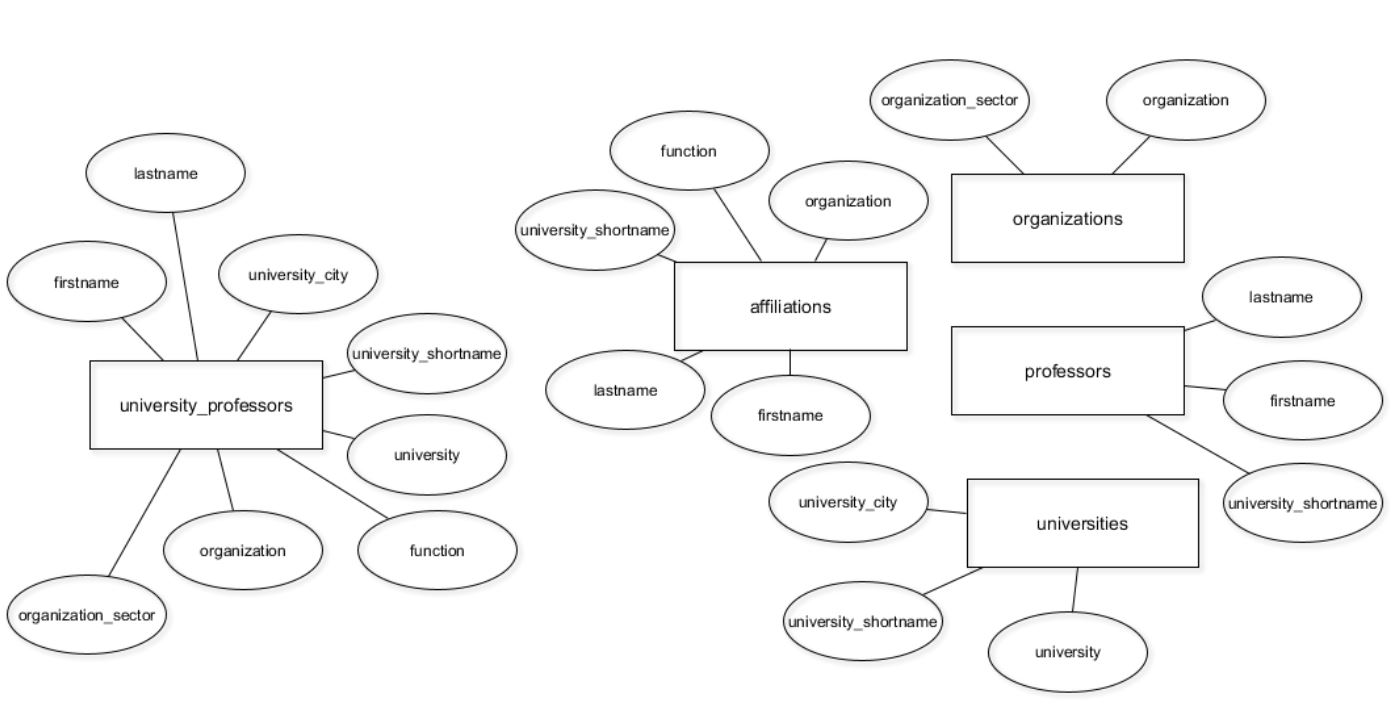

In [15]:
## Now suppose that our current database_model as bellow

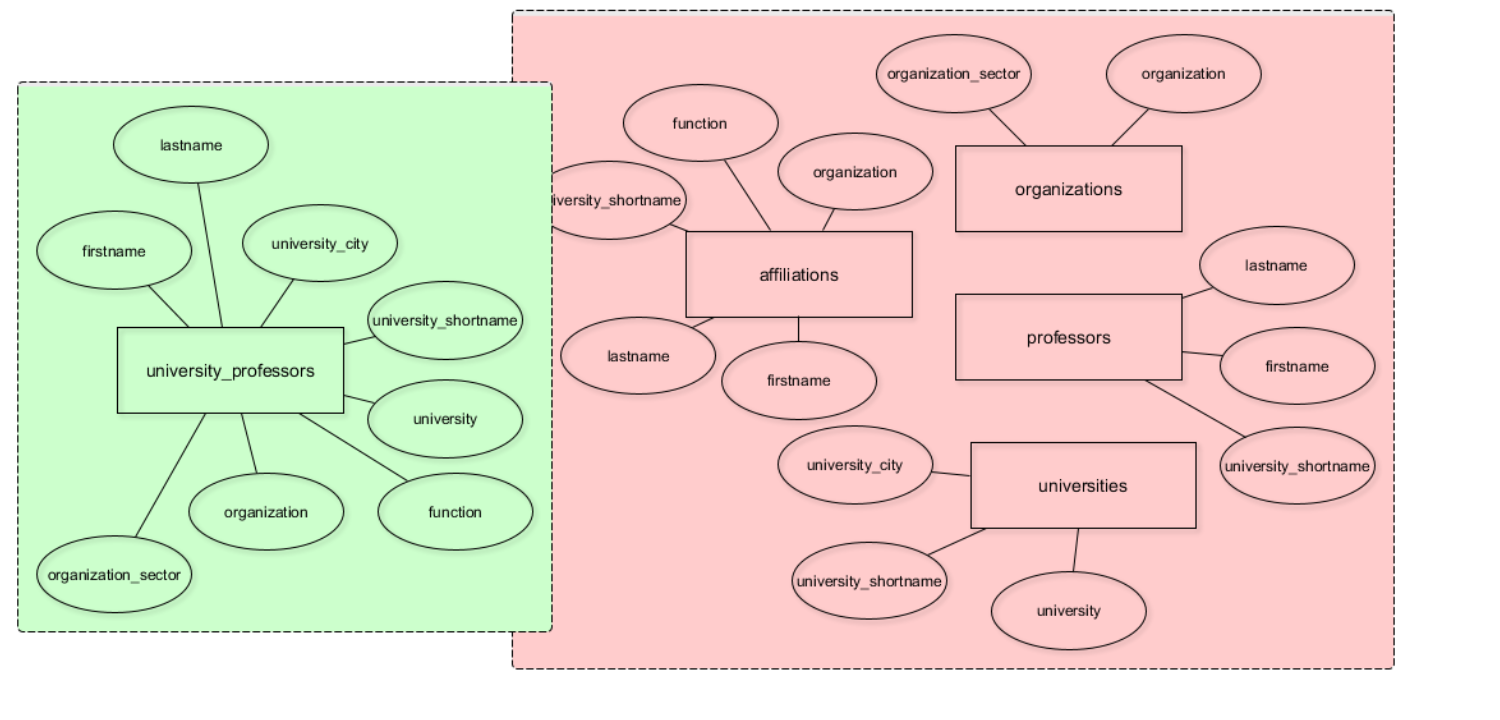

In [16]:
## hidden

#### 3.2. Only store DISTINCT data in the new table, for example

When typing
        
        SELECT COUNT (*) FROM university_professors;
then the query_result will be

| count |
|-------|
| 1377  |

Likewise,
        
        SELECT COUNT (DISTINCT organization) FROM university_professors;
then the query_result will be

| count |
|-------|
| 1287  |

#### 3.3. The INSERT INTO statement

Next, in order to copy a distinct data from the existing table to the new tables, we use the following syntax:

            INSERT INTO new_table
            SELECT DISTINCT records
            FROM existing_table
            
Look at the following picture

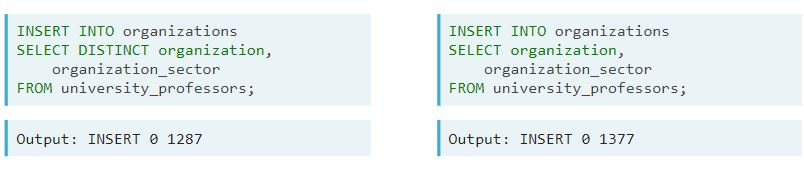

In [17]:
### hidden

The statement **INSERT INTO ... VALUES ...** allowed plug the data into the table step by step! Syntax:

            INSERT INTO table_name (column1, column2) 
            VALUES(val_1, val_2);


#### 3.4. Rename & dropout a column in a table

**Rename**

                CREATE TABLE affilations( firstname text,
                                           lastname text,
                                           university_shortname text,
                                           function text,
                                           organisation text
                                           );
                ALTER TABLE table_name
                RENAME COLUMN old_name TO new_name;
**Drop out. Focus on the last line in each syntax**

                CREATE TABLE affilations( firstname text,
                                           lastname text,
                                           university_shortname text,
                                           function text,
                                           organisation text
                                           );
                ALTER TABLE table_name
                DROP COLUMN column_name;
                                

#### 3.5. The professor is uniquely identified by the first name and last name only.

Look at the following pictures

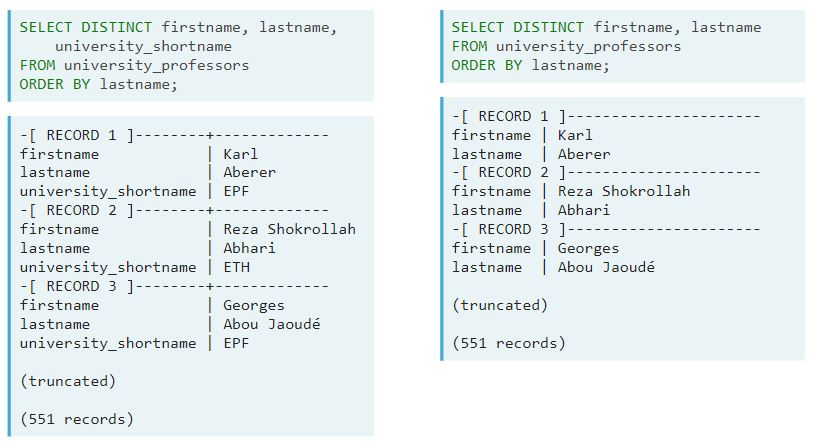

In [18]:
## hidden

This indicated that the `professor` is `uniquely identified` by the `firstname` and `last name`, 

But the `university shortname` is not in the `affilation` table

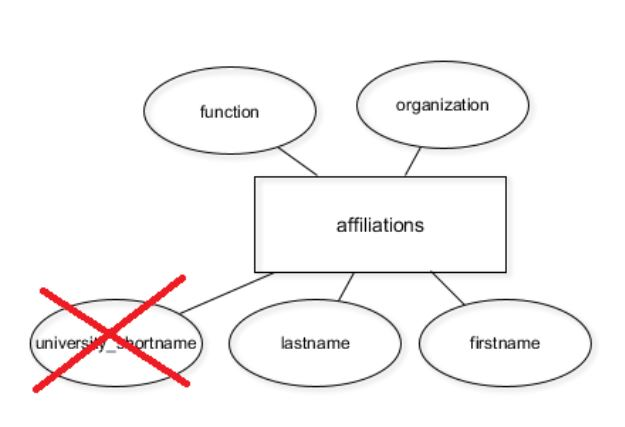

In [19]:
### hidden

### EXERCISEs

#### Exercise 3.1. RENAME and DROP COLUMNs in affiliations
As mentioned in the section 3.4, the still empty `affiliations` table has some `flaws`.

#### Instructions
**Step 1.** Rename the `organisation` column to `organization` in affiliations.
Delete the university_shortname column in affiliations.
**Solution.**

        ALTER TABLE affiliations
        RENAME organisation TO organization;    -- Rename the organisation column

**Step 2.** Delete the `university_shortname` column in `affiliations`.
**Solution.**

        -- Rename the organisation column
        ALTER TABLE affiliations
        RENAME COLUMN organisation TO organization;

        -- Delete the university_shortname column
        ALTER TABLE affiliations
        DROP COLUMN university_shortname;

#### Exercise 3.2. Migrate data with INSERT INTO SELECT DISTINCT
Now it's finally time to migrate the data into the new tables. You'll use the following pattern:

            INSERT INTO ... 
            SELECT DISTINCT ... 
            FROM ...;
It can be broken up into two parts:

First part:

            SELECT DISTINCT column_name1, column_name2, ... 
            FROM table_a;
This selects all distinct values in table table_a – nothing new for you.

Second part:

            INSERT INTO table_b ...;
Take this part and append it to the first, so it inserts all distinct rows from table_a into table_b.

One last thing: It is important that you run all of the code at the same time once you have filled out the blanks.

#### Instructions 
**Step 1.** Insert all **DISTINCT** `professors` from `university_professors` into `professors`. Then print all the first 10 rows in `professors`.

In [20]:
pd.read_sql(
    """ 
    INSERT INTO professors 
    SELECT DISTINCT firstname, lastname, university_shortname 
    FROM university_professors;

    -- Doublecheck the contents of professors
    SELECT * 
    FROM professors
    LIMIT 10
    """, con = engine)

,firstname,lastname,university_shortname
0,Michel,Rappaz,EPF
1,Hilal,Lashuel,EPF
2,Jeffrey,Huang,EPF
3,Pierre,Magistretti,EPF
4,Paolo,Ienne,EPF
5,Frédéric,Kaplan,EPF
6,Olivier,Hari,UNE
7,Christian,Hesse,UBE
8,Majed,Chergui,EPF
9,Douglas,Hanahan,EPF


**Step 2.** Insert all **DISTINCT** `affiliations` into `affiliations` from `university_professors`.

In [21]:
pd.read_sql(
    """ 
    -- Insert unique affiliations into the new table
    INSERT INTO affiliations 
    SELECT DISTINCT firstname, lastname, function, organization 
    FROM university_professors;

    -- Doublecheck the contents of affiliations
    SELECT * 
    FROM affiliations
    LIMIT 10
    """, con = engine)

,firstname,lastname,function,organization
0,Ursula,Wolf,Section Editor,UpToDate
1,Dimos,Poulikakos,VR-Mandat,Scrona AG
2,Francesco,Stellacci,"Co-editor in Chief, Nanoscale","Royal Chemistry Society, UK"
3,Alexander,Fust,Fachexperte und Coach für Designer Startups,Creative Hub
4,Jürgen,Brugger,Proposal reviewing HEPIA,"HES Campus Biotech, Genève"
5,Hervé,Bourlard,Director,Idiap Research Institute
6,Ioannis,Papadopoulos,Mandat,Schweizerischer Nationalfonds (SNF)
7,Olaf,Blanke,Professeur à 20%,Université de Genève
8,Leo,Staub,Präsident Verwaltungsrat,Genossenschaft Migros Ostschweiz
9,Pascal,Pichonnaz,Vize-Präsident,EKK (Eidgenössische Konsumenten Kommission)


#### Exercise 3.3. Delete tables with DROP TABLE
Obviously, the `university_professors` table is now no longer needed and can safely be deleted.

For table deletion, you can use the simple command:

            DROP TABLE table_name;
#### Instructions
Delete the `university_professors` table.

**Solution**

            -- Delete the university_professors table
            DROP TABLE university_professors;

Perfect! Now it's finally time to delve into the real advantages of databases. In the following chapters, you will discover many cool features that ultimately lead to better data consistency and quality, such as domain constraints, keys, and referential integrity. 